In [50]:
% pylab inline

%load_ext autoreload
%autoreload 2
import os
import time
import csv

import requests
import bs4
from bs4 import BeautifulSoup
import pandas as pd
from tqdm import tqdm

import indeed_scraping

%config InlineBackend.figure_format = 'retina'

DATA_DIR = os.path.join(os.getcwd(), 'data')
try:
    os.makedirs(DATA_DIR)
except FileExistsError:
    pass

Populating the interactive namespace from numpy and matplotlib
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Metropolital areas

In [2]:
df_us_cities = pd.read_csv(os.path.join(DATA_DIR, 'uscitiesv1.4.csv'))
df_us_cities['county'] = df_us_cities['county_name']

In [3]:
df_us_cities = df_us_cities[['state_id', 'city', 'county', 'population_proper']].fillna(0)

In [4]:
df_us_cities.head()

,state_id,city,county,population_proper
0,WA,Prairie Ridge,Pierce,0.0
1,WA,Edison,Skagit,0.0
2,WA,Packwood,Lewis,0.0
3,WA,Wautauga Beach,Kitsap,0.0
4,WA,Harper,Kitsap,0.0


In [5]:
df_cbsa = pd.read_csv(os.path.join(DATA_DIR, 'cbsa-est2017-alldata.csv'), encoding = "latin1")

In [6]:
df_cbsa[['CBSA', 'NAME', 'STCOU']].columns

Index(['CBSA', 'NAME', 'STCOU'], dtype='object')

In [7]:
print('Unique number of CBSA:', len(df_cbsa['CBSA'].unique()))

Unique number of CBSA: 933


In [8]:
df_cbsa = df_cbsa[['CBSA', 'NAME', 'STCOU']]
df_cbsa['county'] = df_cbsa['NAME'].apply(lambda x: x.split(', ')[0].replace(' County', ''))
df_cbsa['state_id'] = df_cbsa['NAME'].apply(lambda x: x.split(', ')[1])

In [9]:
df_cbsa.head()

,CBSA,NAME,STCOU,county,state_id
0,24940,"Abbeville County, SC",45001.0,Abbeville,SC
1,10100,"Aberdeen, SD",NaN,Aberdeen,SD
2,10140,"Aberdeen, WA",NaN,Aberdeen,WA
3,10180,"Abilene, TX",NaN,Abilene,TX
4,29180,"Acadia Parish, LA",22001.0,Acadia Parish,LA


In [10]:
df_areas = df_cbsa.join(df_us_cities.set_index(['county', 'state_id']), on=['county', 'state_id'], how='inner')
df_areas = df_areas[['CBSA', 'county', 'state_id', 'city']]

In [11]:
df_areas.head()

,CBSA,county,state_id,city
0,24940,Abbeville,SC,Antreville
0,24940,Abbeville,SC,Donalds
0,24940,Abbeville,SC,Calhoun Falls
0,24940,Abbeville,SC,Lowndesville
0,24940,Abbeville,SC,Lake Secession


In [12]:
df_areas = df_areas.reset_index(drop=True)

### Get demand

In [13]:
df_demand = pd.read_csv(os.path.join(DATA_DIR, 'cyber+security_all_partitions.tsv'), sep='\t')
df_demand = df_demand[['company_name', 'location', 'partition', 'title']]
df_demand['location'] = df_demand['location'].str.strip()

In [14]:
len(df_demand)

23206

In [15]:
df_demand = df_demand[df_demand['location'].apply(lambda x: ', ' in x)]
df_demand['city'] = df_demand['location'].apply(lambda x: x.split(', ')[0])
df_demand['state_id'] = df_demand['location'].apply(lambda x: x.split(', ')[1])

In [16]:
df_demand.head()

,company_name,location,partition,title,city,state_id
0,Jackson-National-Life-Insurance-Company,"Lansing, MI","cyber+security-senior_level-$120,000","AVP, Cybersecurity Response",Lansing,MI
1,Occidental-Petroleum,"Houston, TX","cyber+security-senior_level-$120,000",IT Cyber Security Advisor,Houston,TX
2,\n Ingersoll Consulting Inc.,"Washington, DC","cyber+security-senior_level-$120,000",Cyber Security Engineer - Lead,Washington,DC
3,Saab,"Syracuse, NY","cyber+security-senior_level-$120,000",Senior Staff Systems Engineer; Saab Defense an...,Syracuse,NY
4,\n Executive Office of Energy and Environme...,"Boston, MA","cyber+security-senior_level-$120,000",Chief Information Security Officer,Boston,MA


In [17]:
df_demand_area = (
    df_areas
    .reset_index(drop=True)
    .join(
        df_demand.set_index(['city', 'state_id']), 
        on=['city', 'state_id'], 
        how='right')
    .reset_index(drop=True)
)

In [18]:
df_demand_area.head()

,CBSA,county,state_id,city,company_name,location,partition,title
0,14260.0,Ada,ID,Boise,Dxc-Technology,"Boise, ID","cyber+security-senior_level-$120,000",Segment Chief Information Security Officer- Pu...
1,14260.0,Ada,ID,Boise,General-Dynamics-Information-Technology,"Boise, ID","cyber+security-senior_level-$120,000",Cyber O&M Engineer
2,14260.0,Ada,ID,Boise,General-Dynamics-Information-Technology,"Boise, ID","cyber+security-senior_level-$120,000",Cyber O&M Engineer
3,14260.0,Ada,ID,Boise,Dxc-Technology,"Boise, ID","cyber+security-senior_level-$120,000",Segment Chief Information Security Officer- Pu...
4,14260.0,Ada,ID,Boise,General-Dynamics-Information-Technology,"Boise, ID","cyber+security-senior_level-$120,000",Cyber O&M Engineer


In [19]:
len(df_demand)

22543

In [20]:
df_demand_area['jobs'] = 1
df_demand_count = pd.DataFrame(df_demand_area.groupby('CBSA').count()['jobs'].reset_index())

### Supply

In [21]:
df_supply = pd.read_csv(os.path.join(DATA_DIR, 'resumes_cyber+security_all_partitions.tsv'), sep='\t')
df_supply = df_supply[df_supply['location'].apply(lambda x: isinstance(x, str) and ', ' in x)]
df_supply['city'] = df_supply['location'].apply(lambda x: x.split(', ')[0])
df_supply['state_id'] = df_supply['location'].apply(lambda x: x.split(', ')[1])
df_supply = df_supply[['experience', 'company', 'degree', 'partition', 'city', 'state_id']]

In [22]:
df_supply.head()

,experience,company,degree,partition,city,state_id
0,Computer Operator,First Citizens Bank,Bachelor of Science,resumes-cyber+security-exp_61_120-bachelor,Fuquay-Varina,NC
1,"Senior Analyst, Information Security",General Dynamics Information Technology,Bachelor of Science,resumes-cyber+security-exp_61_120-bachelor,Waynesville,OH
2,Recruiting Assistant,Teleperformance,Bachelors of Science in Computer Science,resumes-cyber+security-exp_61_120-bachelor,Shreveport,LA
3,Network Engineer,Naval Undersea Warfare Center,B.S.,resumes-cyber+security-exp_61_120-bachelor,Buford,GA
4,IT Assistant,Sky Zone Recreational Center,Bachelors,resumes-cyber+security-exp_61_120-bachelor,Chesterfield,MO


In [23]:
df_supply_area = (
    df_areas
    .reset_index(drop=True)
    .join(
        df_supply.set_index(['city', 'state_id']), 
        on=['city', 'state_id'], 
        how='right')
    .reset_index()
)

In [24]:
# df_supply_area['CBSA'] = df_supply_area['CBSA'].astype(int)

In [25]:
df_supply_area.head()

,index,CBSA,county,state_id,city,experience,company,degree,partition
0,7,14260.0,Ada,ID,Boise,Data Center Technician,Microsoft Global Foundation Services,BS,resumes-cyber+security-exp_61_120-bachelor
1,7,14260.0,Ada,ID,Boise,Data Center Technician,Microsoft Global Foundation Services,BS,resumes-cyber+security-exp_61_120-bachelor
2,7,14260.0,Ada,ID,Boise,Data Center Technician,Microsoft Global Foundation Services,BS,resumes-cyber+security-exp_61_120-bachelor
3,7,14260.0,Ada,ID,Boise,Data Center Technician,Microsoft Global Foundation Services,BS,resumes-cyber+security-exp_61_120-bachelor
4,7,14260.0,Ada,ID,Boise,Counselor,Va Department of Corrections,Bachelor of Science,resumes-cyber+security-exp_61_120-bachelor


In [26]:
df_supply_area['resumes'] = 1
df_supply_count = pd.DataFrame(df_supply_area.groupby('CBSA').count()[['resumes']].reset_index())

### Affortability

In [27]:
os.listdir(DATA_DIR)
df_relative_cost = pd.read_csv(os.path.join(DATA_DIR, 'cities_relative_cost.tsv'), sep='\t')
df_relative_cost['location'] = df_relative_cost['city']
df_relative_cost = df_relative_cost.drop(columns=['city'], axis=1)[['location', 'relative_cost']]
df_relative_cost = df_relative_cost.reset_index(drop=True)
df_relative_cost = df_relative_cost[df_relative_cost['location'].apply(lambda x: isinstance(x, str) and ', ' in x)]
df_relative_cost['city'] = df_relative_cost['location'].apply(lambda x: x.split(', ')[0])
df_relative_cost['state_id'] = df_relative_cost['location'].apply(lambda x: x.split(', ')[1])


In [28]:
df_relative_cost_area = (
    df_areas
    .reset_index(drop=True)
    .join(
        df_relative_cost.set_index(['city', 'state_id']), 
        on=['city', 'state_id'], 
        how='right')
    .reset_index()
)

In [29]:
df_relative_cost_area['affortability'] = 1 / df_relative_cost_area['relative_cost']
df_relative_cost_area_mean = df_relative_cost_area[['CBSA', 'affortability']].groupby('CBSA').mean()


In [30]:
df_relative_cost_area_mean.head()

,affortability
CBSA,
10180.0,2.180452
10580.0,1.869011
10740.0,2.179520
10900.0,2.033766
11100.0,2.308799


### Poseidon_score

#### Pull data together

In [31]:
df_relative_cost_area_mean.head()

,affortability
CBSA,
10180.0,2.180452
10580.0,1.869011
10740.0,2.179520
10900.0,2.033766
11100.0,2.308799


In [32]:
df_demand_supply = (
    df_demand_count
    .reset_index(drop=True)
    .join(
        df_supply_count.set_index('CBSA'), 
        how='inner', 
        on='CBSA'))


In [33]:
df_demand_supply.head()

,CBSA,jobs,resumes
0,10420.0,3,61
1,10500.0,1,1
2,10540.0,1,4
3,10580.0,2,125
4,10740.0,23,84


In [34]:
df_supply_demand_relative_cost = (
    df_demand_supply
    .join(
        df_relative_cost_area_mean, 
        how='inner', 
        on='CBSA'))

In [35]:
df_supply_demand_relative_cost.head()

,CBSA,jobs,resumes,affortability
3,10580.0,2,125,1.869011
4,10740.0,23,84,2.179520
5,10900.0,12,91,2.033766
7,11100.0,9,30,2.308799
8,11460.0,3,58,1.768038


In [36]:
df_supply_demand_relative_cost['mean_jobs'] = df_supply_demand_relative_cost['jobs'].mean()
df_supply_demand_relative_cost['mean_resumes'] = df_supply_demand_relative_cost['resumes'].mean()

#### Calculate Poseidon score

In [37]:
def calc_poseidon_score(df): 
    return (df['resumes'] + df['mean_resumes']) / (df['jobs'] + df['mean_jobs']) * df['affortability']
df_poseidon = df_supply_demand_relative_cost
df_poseidon['poseidon_score'] = calc_poseidon_score(df_poseidon)
df_poseidon = df_poseidon.sort_values(by='poseidon_score', ascending=False).reset_index(drop=True)

In [38]:
df_poseidon.to_csv(os.path.join(DATA_DIR, 'posoidon_scores.tsv'), sep='\t')

In [39]:
df_poseidon[:10]

,CBSA,jobs,resumes,affortability,mean_jobs,mean_resumes,poseidon_score
0,41700.0,31,753,2.199351,94.06087,270.304348,17.996084
1,36420.0,6,251,2.269764,94.06087,270.304348,11.825183
2,45300.0,41,593,1.844013,94.06087,270.304348,11.786865
3,40140.0,9,332,1.955115,94.06087,270.304348,11.426006
4,19100.0,216,1454,1.947947,94.06087,270.304348,10.832884
5,41180.0,23,243,2.459756,94.06087,270.304348,10.785872
6,33100.0,38,556,1.602249,94.06087,270.304348,10.025265
7,17820.0,45,419,1.914641,94.06087,270.304348,9.490597
8,46140.0,2,135,2.173913,94.06087,270.304348,9.172272
9,28140.0,10,187,2.073653,94.06087,270.304348,9.112844


In [40]:
df_poseidon[-10:]

,CBSA,jobs,resumes,affortability,mean_jobs,mean_resumes,poseidon_score
105,19380.0,121,99,2.248532,94.06087,270.304348,3.861198
106,42200.0,16,11,1.410927,94.06087,270.304348,3.606186
107,47900.0,2927,5752,1.568199,94.06087,270.304348,3.126111
108,35620.0,1249,2340,1.469075,94.06087,270.304348,2.855220
109,26620.0,532,282,2.259959,94.06087,270.304348,1.993712
110,41940.0,297,338,1.201934,94.06087,270.304348,1.869636
111,41860.0,417,484,1.244465,94.06087,270.304348,1.836778
112,42660.0,516,417,1.556154,94.06087,270.304348,1.753188
113,14460.0,554,468,1.413643,94.06087,270.304348,1.610495
114,29620.0,415,52,2.140669,94.06087,270.304348,1.355333


In [41]:
df_top_cities = pd.read_csv(os.path.join(DATA_DIR, 'top_cities_cyril.csv'))

In [42]:
df_top_cities

,CBSA,city,County,State,state_name
0,45060,Canastota,Madison,NY,New York
1,33100,Fort Lauderdale,Broward,FL,Florida
2,41620,Salt Lake City,Salt Lake,UT,Utah
3,33100,Doral,Miami-Dade,FL,Florida
4,28140,Kansas City,Wyandotte,KS,Kansas
5,36540,Omaha,Douglas,NE,Nebraska
6,17980,Columbus,Muscogee,GA,Georgia
7,38300,Pittsburgh,Allegheny,PA,Pennsylvania
8,31080,Santa Ana,Orange,CA,California
9,40900,Folsom,Sacramento,CA,California


In [43]:
df_poseidon.join(df_top_cities.set_index('CBSA'), on='CBSA', how='right').sort_values(by='poseidon_score', ascending=False)

,CBSA,jobs,resumes,affortability,mean_jobs,mean_resumes,poseidon_score,city,County,State,state_name
6,33100,38,556,1.602249,94.06087,270.304348,10.025265,Fort Lauderdale,Broward,FL,Florida
6,33100,38,556,1.602249,94.06087,270.304348,10.025265,Doral,Miami-Dade,FL,Florida
9,28140,10,187,2.073653,94.06087,270.304348,9.112844,Kansas City,Wyandotte,KS,Kansas
23,38300,41,337,1.734351,94.06087,270.304348,7.798549,Pittsburgh,Allegheny,PA,Pennsylvania
29,36540,18,133,2.113289,94.06087,270.304348,7.605674,Omaha,Douglas,NE,Nebraska
46,40900,15,159,1.712498,94.06087,270.304348,6.741032,Folsom,Sacramento,CA,California
70,41620,23,94,2.012675,94.06087,270.304348,6.263631,Salt Lake City,Salt Lake,UT,Utah
83,17980,7,37,1.878690,94.06087,270.304348,5.712691,Columbus,Muscogee,GA,Georgia
98,31080,258,842,1.557777,94.06087,270.304348,4.921656,Santa Ana,Orange,CA,California
104,45060,85,96,1.963573,94.06087,270.304348,4.016877,Canastota,Madison,NY,New York


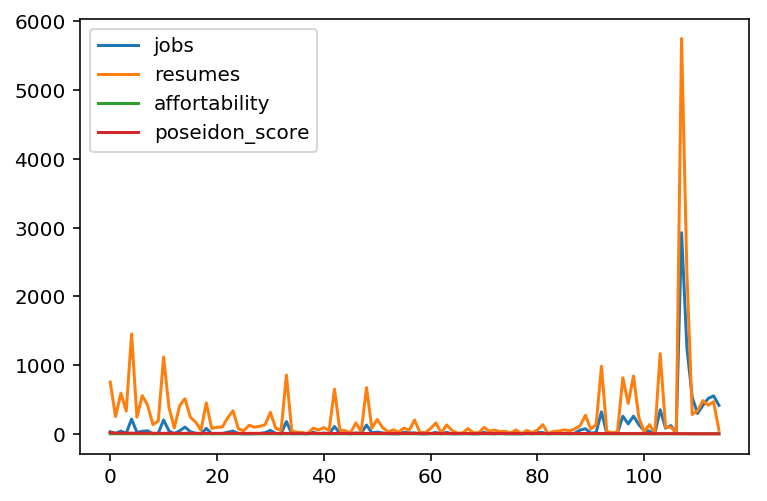

In [53]:
df_poseidon[['jobs', 'resumes', 'affortability','poseidon_score']].plot();

#### Poseidon score of Bay Area

In [44]:
SF_CBSA = ['10500','10580','10540','41860','34980','41940','41180','26900','18140','35620','24860','38300','25540']

In [45]:
df_sf = df_poseidon[df_poseidon['CBSA'].isin(SF_CBSA)]

In [46]:
df_sf['affortability'] = df_sf['affortability'].mean() / len(df_sf['affortability'])

/usr/local/Cellar/python3/3.5.1/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [54]:
print('Poseidon score of SF: {:.2f}'.format(calc_poseidon_score(df_sf.sum())))

Poseidon score of SF: 4.01


Which is in the bottom quarter!!! 